In [8]:
import requests
import pandas as pd
from dateutil import parser, rrule
from datetime import datetime, time, date
import time
import io

 """
    Function to return a data frame of minute-level weather data for a single Wunderground PWS station.
    
    Args:
        station (string): Station code from the Wunderground website
        day (int): Day of month for which data is requested
        month (int): Month for which data is requested
        year (int): Year for which data is requested
    
    Returns:
        Pandas Dataframe with weather data for specified station and date.
    """

def getRainfallData(station, day, month, year):
    url = "http://www.wunderground.com/weatherstation/WXDailyHistory.asp?ID={station}&day={day}&month={month}&year={year}&graphspan=day&format=1"
    full_url = url.format(station=station, day=day, month=month, year=year)

    #Request data from wunderground data

    response = requests.get(full_url, headers={'User-agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'})
    data = response.text

    #remove the excess <br> from the text data
    
    data = data.replace('<br>', '')
    try:
        dataframe = pd.read_csv(io.StringIO(data),index_col=False)
        dataframe['station'] = station
    except Exception as e:
        print("Issue with date: {}-{}-{} for station {}".format(day,month,year,station))
        return None
    return dataframe    

    #Generate a list of all of the dates we want data for

start_date = "2015-01-01"
end_date = "2015-12-31"
start = parser.parse(start_date)
end = parser.parse(end_date)
dates = list(rrule.rrule(rrule.DAILY, dtstart=start, until=end))    

    #Create a list of stations here to download data for
## "IDUBLINF2", "ICARRAIG2", "IGALWAYR2", "IBELFAST4", "ILONDON59", "IILEDEFR28"
stations = ["IDUBLINF3"]
    #Set a backoff time in seconds if a request fails
backoff_time = 10
data = {}

for station in stations:
    print("Working on {}".format(station))
    data[station] = []
    for date in dates:

        #   Print period status update messages
        if date.day % 10 == 0:
            print("Working on date {} for station {}".format(date,station))
        done = False
        while done == False:
            try:
                weather_data = getRainfallData(station, date.day, date.month, date.year)
                done = True
            except ConnectionError as e:
                #May get rate limited by Wunderground.com, backoff if so.

                print("Got connection error on date {}".format(date))
                print("Will try in {} seconds ".format(backoff_time))
                time.sleep(10)
            #Add each processed date to the overall data
        data[station].append(weather_data)
        
        #Finally combine all of the individual days and output to CSV for analysis.
    pd.concat(data[station]).to_csv("/Users/amitpatel/Desktop/weather_data/{}_weather.csv".format(station))

In [9]:
station = 'IDUBLINF3' # Edinburgh
data_raw = pd.read_csv("/Users/amitpatel/Desktop/weather_data/{}_weather.csv".format(station))


In [10]:

# Give the variables some friendlier names and convert types as necessary.

data_raw['temp'] = data_raw['TemperatureC'].astype(float)
data_raw['rain'] = data_raw['HourlyPrecipMM'].astype(float)
data_raw['total_rain'] = data_raw['dailyrainMM'].astype(float)
data_raw['date'] = data_raw['DateUTC'].apply(parser.parse)
data_raw['humidity'] = data_raw['Humidity'].astype(float)
data_raw['wind_direction'] = data_raw['WindDirectionDegrees']
data_raw['wind'] = data_raw['WindSpeedKMH']

# Extract out only the data we need.

data = data_raw.loc[:,['date','station','temp','rain','total_rain','humidity','wind']]
data = data[(data['date'] >= datetime(2015,1,1))  &  (data['date'] <= datetime(2015,12,31))]

# There's an issue with some stations that record rainfall ~-2500 where data is missing.

if (data['rain'] < -500 ).sum() > 10:
    print("There are more than 10 messed up days for station {}".format(station))
    
data = data[data['rain'] > -500]
data.head()

There are more than 10 messed up days for station IDUBLINF3


,date,station,temp,rain,total_rain,humidity,wind
29,2015-01-01 07:25:00,IDUBLINF3,9.8,0.0,0.0,91.0,-1607.4
30,2015-01-01 07:35:00,IDUBLINF3,9.8,0.0,0.0,90.0,-1607.4
31,2015-01-01 08:08:00,IDUBLINF3,10.0,0.3,0.3,89.0,-1607.4
32,2015-01-01 08:13:00,IDUBLINF3,9.9,0.5,0.5,90.0,-1607.4
33,2015-01-01 08:38:00,IDUBLINF3,9.9,0.3,0.5,91.0,-1607.4


In [11]:
# Assign the "day" to every date entry
data['day'] = data['date'].apply(lambda x:x.date())
data['time_of_day'] = data['date'].apply(lambda x:x.time())
data['day_of_week'] = data['date'].apply(lambda x:x.weekday())
data['hour_of_day'] = data['date'].apply(lambda x:x.hour)
data['month'] = data['date'].apply(lambda x:x.month)

from datetime import time
# Is each time stamp on a working day (Mon-Fri)

data['working_day'] = (data['day_of_week'] >= 0) & (data['day_of_week'] <= 4)

# Classify into morning or evening times (assuming travel between 8.15-9am and 5.15-6pm)

data['morning'] = (data['time_of_day'] >= time(8,15)) & (data['time_of_day'] <= time(9,0))
data['evening'] = (data['time_of_day'] >= time(17,15)) & (data['time_of_day'] <= time(18,0))

# If there's any rain at all, mark that!

data['raining'] = data['rain'] > 0.0

# You get wet cycling if its a working day, and its raining at the travel times!

data['get_wet_cycling'] = (data['working_day']) & ((data['morning'] & data['raining']) | (data['evening'] & data['raining']))

In [12]:
# Looking at the working days only and create a daily data set of working days:

wet_cycling = data[data['working_day'] == True].groupby('day')['get_wet_cycling'].any()
wet_cycling = pd.DataFrame(wet_cycling).reset_index()
wet_cycling['month'] = wet_cycling['day'].apply(lambda x:x.month)

# Group by month for display - monthly data set for plots.

monthly = wet_cycling.groupby(['month','get_wet_cycling'], as_index = False).count()
monthly.head()

,month,get_wet_cycling,day
0,1,False,11
1,1,True,4
2,2,False,5
3,2,True,2
4,3,False,9


In [13]:
wet_cycling = data[data['working_day'] == True].groupby('day')['get_wet_cycling'].any()
wet_cycling = pd.DataFrame(wet_cycling).reset_index()
wet_cycling['month'] = wet_cycling['day'].apply(lambda x:x.month)
monthly = wet_cycling.groupby(['month','get_wet_cycling'], as_index = False).count()
monthly.rename(columns={"get_wet_cycling":"Rainy"}, inplace = True)
monthly.replace({"Rainy":{True:"Wet",False:"Dry"}}, inplace = True)
import calendar
monthly['month_name'] = monthly['month'].apply(lambda x: calendar.month_abbr[x])

# Get aggregate stats for each day in the dataset on rain in general - for heatmaps.

rainy_days = data.groupby(['day']).agg({
    "rain": {"rain": lambda x: (x>0.0).any(),
            "rain_amount":"sum"},
    "total_rain":{"total_rain":"max"},
    "get_wet_cycling":{"get_wet_cycling":"any"}
})
rainy_days.head()


/Users/amitpatel/anaconda3/lib/python3.6/site-packages/pandas/core/groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


rain             total_rain get_wet_cycling
            rain rain_amount total_rain get_wet_cycling
day                                                    
2015-01-01  True         7.3        2.3            True
2015-01-03  True        25.9        9.1           False
2015-01-06  True         0.9        0.5           False
2015-01-07  True         9.2        3.3           False
2015-01-08  True         3.3        1.3           False

In [14]:
rainy_days.reset_index(drop = False, inplace = True)
rainy_days.rename(columns = {"":"date"})
rainy_days.columns = rainy_days.columns.droplevel(level=0)
rainy_days.head()

,,rain,rain_amount,total_rain,get_wet_cycling
0,2015-01-01,True,7.3,2.3,True
1,2015-01-03,True,25.9,9.1,False
2,2015-01-06,True,0.9,0.5,False
3,2015-01-07,True,9.2,3.3,False
4,2015-01-08,True,3.3,1.3,False


In [15]:
rainy_days = rainy_days.rename(columns={"":"date"})
rainy_days.head()

,date,rain,rain_amount,total_rain,get_wet_cycling
0,2015-01-01,True,7.3,2.3,True
1,2015-01-03,True,25.9,9.1,False
2,2015-01-06,True,0.9,0.5,False
3,2015-01-07,True,9.2,3.3,False
4,2015-01-08,True,3.3,1.3,False


In [16]:
temp = data.groupby(["day","hour_of_day"])['raining'].any()
temp = temp.groupby(level=[0]).sum().reset_index()
temp.rename(columns={"raining":"hours_raining"}, inplace = True)
temp['day'] = temp['day'].apply(lambda x: x.to_pydatetime().date())
rainy_days = rainy_days.merge(temp, left_on = 'date', right_on = 'day', how='left')
temp.head()

,day,hours_raining
0,2015-01-01,5.0
1,2015-01-03,10.0
2,2015-01-06,2.0
3,2015-01-07,6.0
4,2015-01-08,4.0


In [17]:

rainy_days.drop('day', axis=1, inplace = True)

In [18]:
rainy_days.head()

,date,rain,rain_amount,total_rain,get_wet_cycling,hours_raining
0,2015-01-01,True,7.3,2.3,True,5.0
1,2015-01-03,True,25.9,9.1,False,10.0
2,2015-01-06,True,0.9,0.5,False,2.0
3,2015-01-07,True,9.2,3.3,False,6.0
4,2015-01-08,True,3.3,1.3,False,4.0


In [19]:
monthly.head()

,month,Rainy,day,month_name
0,1,Dry,11,Jan
1,1,Wet,4,Jan
2,2,Dry,5,Feb
3,2,Wet,2,Feb
4,3,Dry,9,Mar


Text(0.5,1,'Wet or Dry Commuting in Edinburgh')

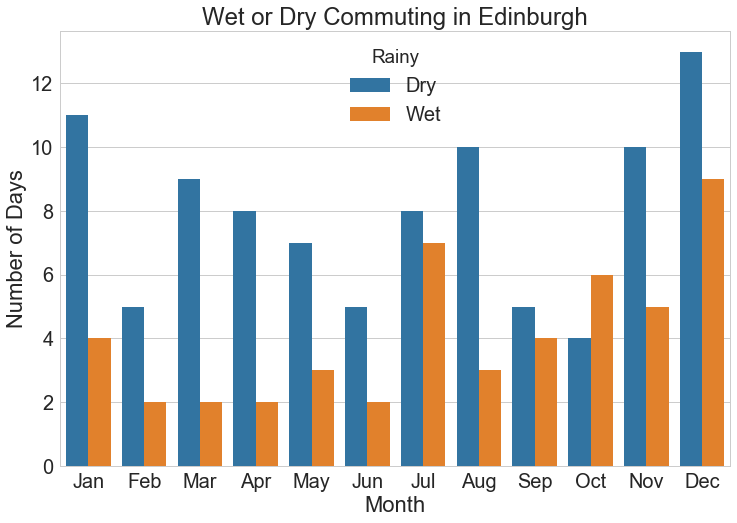

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,8))
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=2)
sns.barplot(x="month_name", y="day", hue="Rainy", data=monthly.sort_values(['month', 'Rainy']))
plt.xlabel("Month")
plt.ylabel("Number of Days")
plt.title("Wet or Dry Commuting in Edinburgh")

In [27]:
#import calmap

#temp = rainy_days.copy().set_index(pd.DatetimeIndex(['rain_amount']))
#temp.set_index('date', inplace=True)
#fig, ax = calmap.calendarplot(temp['hours_raining'], fig_kws={"figsize":(15,4)})
#plt.title("Hours raining")
#fig, ax = calmap.calendarplot(temp['total_rain'], fig_kws={"figsize":(15,4)})
#plt.title("Total Rainfall Daily")

Text(0.5,1,'Wet or Dry Commuting in Edinburgh')

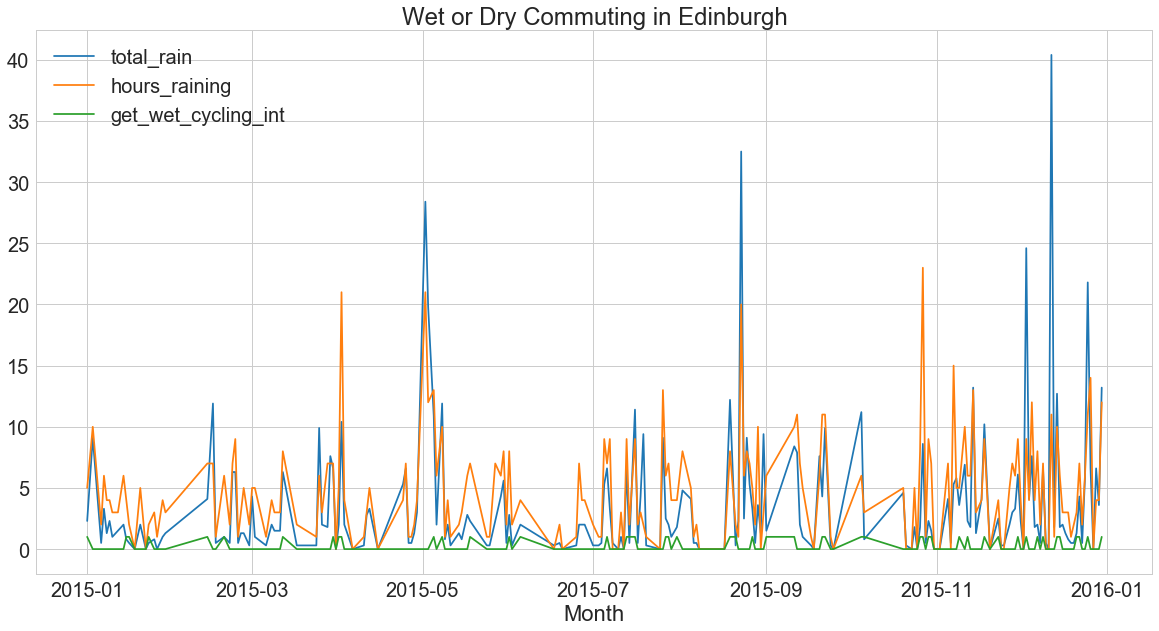

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
tmp = rainy_days.copy()
tmp.replace({"get_wet_cycling":{True:"1",False:"0"}},inplace = True)
tmp['get_wet_cycling_int'] = tmp['get_wet_cycling'].astype(int)
#tmp.head()

tmp = tmp[['date','get_wet_cycling_int','hours_raining','total_rain']]
#tmp['date'] = tmp['date'].apply(lambda x: x.strftime("%Y %B"))
tmp = tmp.set_index(tmp['date'])
tmp[['total_rain','hours_raining','get_wet_cycling_int']].plot(figsize = (20,10));
plt.xlabel("Month")
plt.title("Wet or Dry Commuting in Edinburgh")
#tmp.head()

In [93]:
This visualisation is concerned with understanding on how likely it is to get wet when cycling to work. The weather underground site is scrapped to get the rainfall data of the Edinburgh city. The data is then transformed to obtain 
- The number of hours it rained on the given day,
- Get wet when cycling to work (Assuming the commute time 8:15-9 am in the morning and 5:15-6pm in the evening)
- Total rain on each day.

The data for Jan 2015 -  Dec 2015 is plotted by date to observe the tends of the number of hours it has rained, total rain and rained in the morning/evening office commute time. From the graph the reader can point out that Edinburgh gets rain through out the year, however the month of July, October, November and December has more number of days with the downpour in comparison with the other months. With this observation it is more clear that these are the months in which the rider gets wet more often when commuting to work.
 

SyntaxError: invalid syntax (<ipython-input-93-ef058cca99c5>, line 1)